# Predicting Zillow´s rental price index

## 1. Import libraries and dataframe.

### 1.1 Import libraries

In [115]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import os
import matplotlib 
from matplotlib import pyplot as plt
import math

### 1.2 Import dataframe

In [116]:
# Import dataframe
os.chdir('C:/Users/Guillermo/Desktop/ESTUDIOS/Data Science Bootcamp/Projects/4. Capstone/Data')
df = pd.read_csv('df.csv')

## 2. Data Preprocessing

### 2.1 Split dataframe

#### Split the dataframe between a training and a testing dataframes in order to be able to evaluate our predictions.

In [117]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns != '2017-12'], df['2017-12'], test_size=0.2, random_state = 5)

### 2.2 Missing values

#### In a first exploration we check the number of rows with missing values and the total number of missing values in the training set. This reveals a high number of missing values spread over several variables. Especially, few variables have a high number of missing values. 

#### In order to have a visual representation a plot with the proportion of missing values per variable in the training set is created below.

The number of missing values in the training set is 36419.
The number of rows with missing values in the training set is 3532.


Text(0, 0.5, 'Variables')

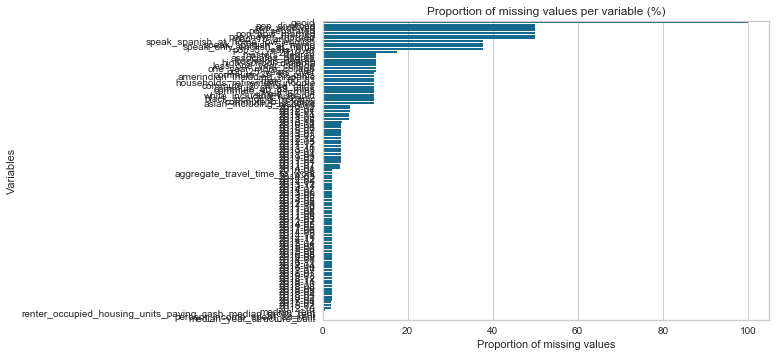

In [118]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))

# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

# Overview of missing values per variable
df1 = pd.DataFrame(round(((x_train.isna().sum())/x_train.shape[0])*100,2)).reset_index()
df1.rename(columns = {'index':'variables', 0:'missing_values'}, inplace = True)
df1 = df1[df1['missing_values'] > 12].sort_values(ascending = False, by = 'missing_values')
sns.barplot(x = 'missing_values', y = 'variables', data = df1, color = 'b')
plt.title('Proportion of missing values per variable (%)', loc = 'center')
plt.xlabel('Proportion of missing values')
plt.ylabel('Variables')


#### Now, we check the number of rows with missing values and the total number of missing values in the testing set. Again, this reveals a high number of missing values spread over several variables. In addition, we can see that one variable, Electrical, has only one missing value and that it fell in the testing set when the split was done. Therefore, there is an additional feature we have to impute in the testing set in comparison to the training set. 

#### Again, in order to have a visually representation a plot with the proportion of missing values per variable in the testing set is created.

The number of missing values in the testing set is 9373.
The number of rows with missing values in the testing set is 884.


Text(0, 0.5, 'Variables')

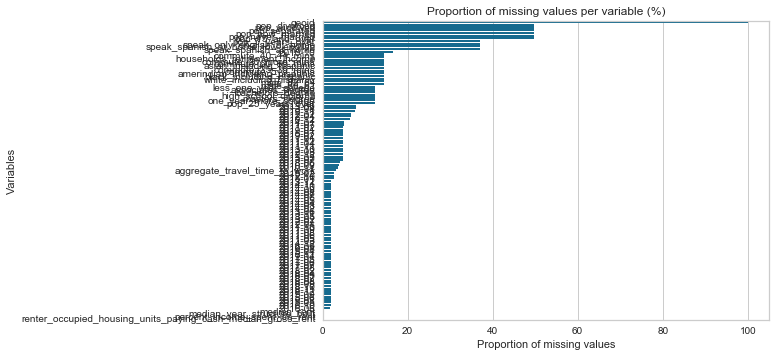

In [119]:
# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))

# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))

# Overview of missing values per variable
df1 = pd.DataFrame(round(((x_test.isna().sum())/x_test.shape[0])*100,2)).reset_index()
df1.rename(columns = {'index':'variables', 0:'missing_values'}, inplace = True)
df1 = df1[df1['missing_values'] > 12].sort_values(ascending = False, by = 'missing_values')
sns.barplot(x = 'missing_values', y = 'variables', data = df1, color = 'b')
plt.title('Proportion of missing values per variable (%)', loc = 'center')
plt.xlabel('Proportion of missing values')
plt.ylabel('Variables')

#### All of our variables are numeric. We imput using the median. We do so trying to keep the imputation as local as possible. We start imputing the median of the city and move to the State for the values that remain missing.
#### We impute in the testing set using the training set as a reference.

In [120]:
missing_values_featues = x_train.isna().sum().reset_index().rename(columns = {0:'missing_values'})
for feature in list(missing_values_featues[missing_values_featues['missing_values'] > 0].iloc[:,0]):
    # We start at the city level
    x_train[feature] = x_train.groupby('City')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['City'].iloc[i] in list(x_train['City'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('City')[feature].median()[x_test['City'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()
    # Next we move to the state level
    x_train[feature] = x_train.groupby('State')[feature].transform(lambda x: x.fillna(x.median()))
    for i in range(0, x_test.shape[0]):
        if x_test['State'].iloc[i] in list(x_train['State'].unique()):
            x_test[feature].iloc[i] = x_train.groupby('State')[feature].median()[x_test['State'].iloc[i]]
        else:
            x_test[feature].iloc[i] = x_train[feature].median()

#### geoid does not contain relevant information as we can use geo_id instead. Therefore, we drop it.

In [121]:
x_train.drop(columns = ['geoid'], inplace = True)
x_test.drop(columns = ['geoid'], inplace = True)

#### City and State provides no information as all our locations are in Phoenix.

In [122]:
x_train.drop(columns = ['City', 'State'], inplace = True)
x_test.drop(columns = ['City', 'State'], inplace = True)

#### Check the number of missing values in the training and testing sets.

In [123]:
# Total number of missing values in the training set
print('The number of missing values in the training set is {}.'.format(x_train.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the training set is {}.'.format(x_train.shape[0] - x_train.dropna().shape[0]))

print(' ')

# Total number of missing values in the testing set
print('The number of missing values in the testing set is {}.'.format(x_test.isna().sum().sum()))
# Total number of rows with missing values. 
print('The number of rows with missing values in the testing set is {}.'.format(x_test.shape[0] - x_test.dropna().shape[0]))


The number of missing values in the training set is 0.
The number of rows with missing values in the training set is 0.
 
The number of missing values in the testing set is 0.
The number of rows with missing values in the testing set is 0.


### 2.3 Feature engineering

#### In order to check for multicollinearity among our numerical variables, me plot the correlation matrix of our features.

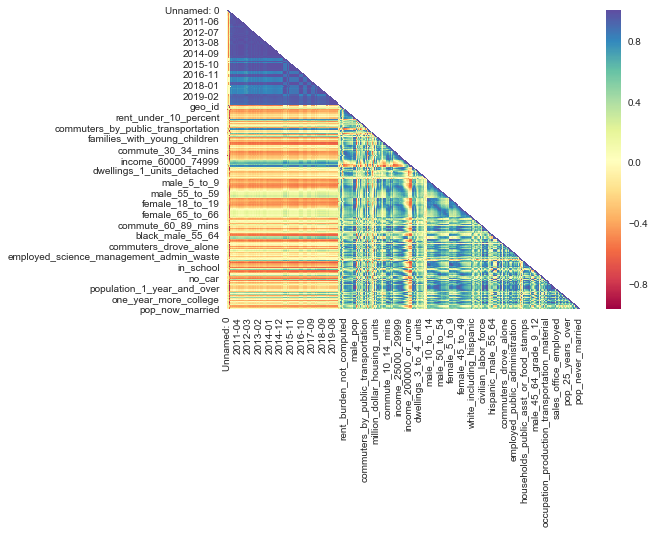

In [124]:
num_features = x_train.select_dtypes(include = ['int64', 'float64'])
corr_x_train =  num_features.corr(method = 'pearson') 
matrix = corr_x_train.where(np.tril(np.ones(corr_x_train.shape)).astype(np.bool))

hmap = sns.heatmap(matrix, cmap = "Spectral")
hmap

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

num_features = x_train.select_dtypes(include = ['int64', 'float64'])
vif_data = pd.DataFrame() 
vif_data["feature"] = num_features.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(num_features.values, i) 
                          for i in range(len(num_features.columns))] 
  
vif = pd.DataFrame(vif_data).sort_values(by = 'VIF', ascending = False)
print(vif)

In [ ]:
#x = pd.DataFrame(vif_data).sort_values(by = 'VIF', ascending = False)
#x

In [127]:
#for i in list(x['feature']):
#    print(i)

#### Location variables: since all our zipcodes are in Phoenix, variables providing information about the city, state, metro or county don´t provide any extra information. Therefore, we drop them.

In [128]:
x_train.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)
x_test.drop(columns = ['Metro', 'CountyName', 'RegionID'], inplace = True)

#### do_date doesn´t provide any information about the dependent variable. Therefore, we drop it.

In [129]:
x_train.drop(columns = ['do_date'], inplace = True)
x_test.drop(columns = ['do_date'], inplace = True)

#### Unnamed is an index variable that it´s not necessary. Therefore, we drop it

In [130]:
x_train.drop(columns = ['Unnamed: 0'], inplace = True)
x_test.drop(columns = ['Unnamed: 0'], inplace = True)

#### SizeRank is just an ordering of size. We drop it.

In [131]:
x_train.drop(columns = ['SizeRank'], inplace = True)
x_test.drop(columns = ['SizeRank'], inplace = True)

#### RegionName is not a variable that we are going to use to predict as geo_id contains the same information.

In [132]:
x_train.drop(columns = ['RegionName'], inplace = True)
x_test.drop(columns = ['RegionName'], inplace = True)

#### year is not a variable that we are using to predict. Therefore, we drop it.

In [ ]:
x_train.drop(columns = ['year'], inplace = True)
x_test.drop(columns = ['year'], inplace = True)

#### Grouping female age columns together

In [134]:
# x_train
x_train['female_under_18'] = x_train.female_under_5 + x_train.female_5_to_9 + x_train.female_10_to_14 + x_train.female_15_to_17 + x_train.female_18_to_19
x_train['female_under_60'] = x_train.female_20 + x_train.female_21 + x_train.female_22_to_24 + x_train.female_25_to_29 + x_train.female_30_to_34 + x_train.female_35_to_39 + x_train.female_40_to_44 + x_train.female_45_to_49 + x_train.female_50_to_54 + x_train.female_55_to_59 
x_train['female_over_60'] = x_train.female_60_to_61 + x_train.female_62_to_64 + x_train.female_65_to_66 + x_train.female_67_to_69 + x_train.female_70_to_74 + x_train.female_75_to_79 + x_train.female_80_to_84 + x_train.female_85_and_over

In [135]:
# x_test
x_test['female_under_18'] = x_test.female_under_5 + x_test.female_5_to_9 + x_test.female_10_to_14 + x_test.female_15_to_17 + x_test.female_18_to_19
x_test['female_under_60'] = x_test.female_20 + x_test.female_21 + x_test.female_22_to_24 + x_test.female_25_to_29 + x_test.female_30_to_34 + x_test.female_35_to_39 + x_test.female_40_to_44 + x_test.female_45_to_49 + x_test.female_50_to_54 + x_test.female_55_to_59 
x_test['female_over_60'] = x_test.female_60_to_61 + x_test.female_62_to_64 + x_test.female_65_to_66 + x_test.female_67_to_69 + x_test.female_70_to_74 + x_test.female_75_to_79 + x_test.female_80_to_84 + x_test.female_85_and_over

#### Grouping male age columns together

In [136]:
# x_train
x_train['male_under_18'] = x_train.male_under_5 + x_train.male_5_to_9 + x_train.male_10_to_14 + x_train.male_15_to_17 + x_train.male_18_to_19
x_train['male_under_60'] = x_train.male_20 + x_train.male_21 + x_train.male_22_to_24 + x_train.male_25_to_29 + x_train.male_30_to_34 + x_train.male_35_to_39 + x_train.male_40_to_44 + x_train.male_45_to_49 + x_train.male_50_to_54 + x_train.male_55_to_59 
x_train['male_over_60'] = x_train.male_60_61 + x_train.male_62_64 + x_train.male_65_to_66 + x_train.male_67_to_69 + x_train.male_70_to_74 + x_train.male_75_to_79 + x_train.male_80_to_84 + x_train.male_85_and_over

In [137]:
# x_test
x_test['male_under_18'] = x_test.male_under_5 + x_test.male_5_to_9 + x_test.male_10_to_14 + x_test.male_15_to_17 + x_test.male_18_to_19
x_test['male_under_60'] = x_test.male_20 + x_test.male_21 + x_test.male_22_to_24 + x_test.male_25_to_29 + x_test.male_30_to_34 + x_test.male_35_to_39 + x_test.male_40_to_44 + x_test.male_45_to_49 + x_test.male_50_to_54 + x_test.male_55_to_59 
x_test['male_over_60'] = x_test.male_60_61 + x_test.male_62_64 + x_test.male_65_to_66 + x_test.male_67_to_69 + x_test.male_70_to_74 + x_test.male_75_to_79 + x_test.male_80_to_84 + x_test.male_85_and_over

#### Grouping rent affordability columns together

In [138]:
# x_train
x_train['under10'] = x_train.rent_under_10_percent
x_train['tento50'] = x_train.rent_40_to_50_percent + x_train.rent_35_to_40_percent + x_train.rent_30_to_35_percent+ x_train.rent_25_to_30_percent + x_train.rent_20_to_25_percent + x_train.rent_15_to_20_percent +x_train.rent_10_to_15_percent
x_train['over50'] = x_train.rent_over_50_percent
x_train['uncomputed'] = x_train.rent_burden_not_computed

In [139]:
# x_test
x_test['under10'] = x_test.rent_under_10_percent
x_test['tento50'] = x_test.rent_40_to_50_percent + x_test.rent_35_to_40_percent + x_test.rent_30_to_35_percent+ x_test.rent_25_to_30_percent + x_test.rent_20_to_25_percent + x_test.rent_15_to_20_percent + x_test.rent_10_to_15_percent
x_test['over50'] = x_test.rent_over_50_percent
x_test['uncomputed'] = x_test.rent_burden_not_computed

#### Grouping dwellings columns together

In [140]:
# x_train
x_train['small_dwellings'] = x_train.dwellings_1_units_attached + x_train.dwellings_1_units_detached + x_train.dwellings_2_units + x_train.dwellings_3_to_4_units + x_train.dwellings_5_to_9_units
x_train['large_dwellings'] = x_train.dwellings_10_to_19_units + x_train.dwellings_20_to_49_units + x_train.dwellings_50_or_more_units

In [141]:
# x_test
x_test['small_dwellings'] = x_test.dwellings_1_units_attached + x_test.dwellings_1_units_detached + x_test.dwellings_2_units + x_test.dwellings_3_to_4_units + x_test.dwellings_5_to_9_units
x_test['large_dwellings'] = x_test.dwellings_10_to_19_units + x_test.dwellings_20_to_49_units + x_test.dwellings_50_or_more_units

#### Grouping commute time together

In [142]:
# x_train
x_train['commute_less_than_30'] = x_train.commute_5_9_mins + x_train.commute_less_10_mins + x_train.commute_10_14_mins + x_train.commute_15_19_mins + x_train.commute_20_24_mins + x_train.commute_25_29_mins
x_train['commute_less_than_60'] = x_train.commute_30_34_mins + x_train.commute_35_39_mins + x_train.commute_35_44_mins + x_train.commute_40_44_mins + x_train.commute_45_59_mins
x_train['commute_over_60'] = x_train.commute_60_89_mins + x_train.commute_60_more_mins + x_train.commute_90_more_mins

In [143]:
# x_test
x_test['commute_less_than_30'] = x_test.commute_5_9_mins + x_test.commute_less_10_mins + x_test.commute_10_14_mins + x_test.commute_15_19_mins + x_test.commute_20_24_mins + x_test.commute_25_29_mins
x_test['commute_less_than_60'] = x_test.commute_30_34_mins + x_test.commute_35_39_mins + x_test.commute_35_44_mins + x_test.commute_40_44_mins + x_test.commute_45_59_mins
x_test['commute_over_60'] = x_test.commute_60_89_mins + x_test.commute_60_more_mins + x_test.commute_90_more_mins

#### Grouping income levels together

In [144]:
# x_train
x_train['income_less_than_60000'] = x_train.income_less_10000 + x_train.income_10000_14999 + x_train.income_15000_19999 + x_train.income_20000_24999 + x_train.income_25000_29999 + x_train.income_30000_34999 + x_train.income_35000_39999 + x_train.income_40000_44999 + x_train.income_45000_49999 + x_train.income_50000_59999
x_train['income_less_than_125000'] = x_train.income_60000_74999 + x_train.income_75000_99999 + x_train.income_100000_124999
x_train['income_over_125000'] = x_train.income_125000_149999 + x_train.income_150000_199999 + x_train.income_200000_or_more

In [146]:
# x_test
x_test['income_less_than_60000'] = x_test.income_less_10000 + x_test.income_10000_14999 + x_test.income_15000_19999 + x_test.income_20000_24999 + x_test.income_25000_29999 + x_test.income_30000_34999 + x_test.income_35000_39999 + x_test.income_40000_44999 + x_test.income_45000_49999 + x_test.income_50000_59999
x_test['income_less_than_125000'] = x_test.income_60000_74999 + x_test.income_75000_99999 + x_test.income_100000_124999
x_test['income_over_125000'] = x_test.income_125000_149999 + x_test.income_150000_199999 + x_test.income_200000_or_more

#### Grouping employment industries together

In [147]:
# x_train
x_train['employed_creative'] = x_train.employed_arts_entertainment_recreation_accommodation_food
x_train['employed_prof'] = x_train.employed_education_health_social + x_train.employed_finance_insurance_real_estate + x_train.employed_information + x_train.employed_science_management_admin_waste
x_train['employed_skill'] = x_train.employed_manufacturing + x_train.employed_construction + x_train.employed_agriculture_forestry_fishing_hunting_mining
x_train['employed_service'] = x_train.employed_retail_trade + x_train.employed_other_services_not_public_admin + x_train.employed_public_administration + x_train.employed_transportation_warehousing_utilities + x_train.employed_wholesale_trade

In [148]:
# x_test
x_test['employed_creative'] = x_test.employed_arts_entertainment_recreation_accommodation_food
x_test['employed_prof'] = x_test.employed_education_health_social + x_test.employed_finance_insurance_real_estate + x_test.employed_information + x_test.employed_science_management_admin_waste
x_test['employed_skill'] = x_test.employed_manufacturing + x_test.employed_construction + x_test.employed_agriculture_forestry_fishing_hunting_mining
x_test['employed_service'] = x_test.employed_retail_trade + x_test.employed_other_services_not_public_admin + x_test.employed_public_administration + x_test.employed_transportation_warehousing_utilities + x_test.employed_wholesale_trade

#### Choosing family type columns

In [149]:
# x_train
x_train['two_parent_hh'] = x_train.two_parent_families_with_young_children.astype(float)
x_train['one_parent_hh'] = x_train.one_parent_families_with_young_children.astype(float)

In [150]:
# x_test
x_test['two_parent_hh'] = x_test.two_parent_families_with_young_children.astype(float)
x_test['one_parent_hh'] = x_test.one_parent_families_with_young_children.astype(float)

In [152]:
#pop_columns = [asian_pop, amerindian_pop, black_pop, hispanic_pop, white_pop, amerindian_including_hispanic,other_race_pop,two_or_more_races_pop]

#### Grouping education level columns together

In [153]:
# x_train
x_train['college_educated'] = x_train.in_undergrad_college + x_train.some_college_and_associates_degree + x_train.associates_degree + x_train.bachelors_degree + x_train.bachelors_degree_2 + x_train.bachelors_degree_or_higher_25_64 + x_train.masters_degree + x_train.graduate_professional_degree + x_train.one_year_more_college     
x_train['in_school'] = x_train.in_grades_1_to_4 + x_train.in_grades_5_to_8 + x_train.in_grades_9_to_12
x_train['inschoolcheck'] = x_train.in_school
x_train['less_than_college_educated'] = x_train.less_one_year_college + x_train.less_one_year_college
x_train['high_school_educated'] = x_train.high_school_diploma + x_train.high_school_including_ged

In [154]:
# x_test
x_test['college_educated'] = x_test.in_undergrad_college + x_test.some_college_and_associates_degree + x_test.associates_degree + x_test.bachelors_degree + x_test.bachelors_degree_2 + x_test.bachelors_degree_or_higher_25_64 + x_test.masters_degree + x_test.graduate_professional_degree + x_test.one_year_more_college     
x_test['in_school'] = x_test.in_grades_1_to_4 + x_test.in_grades_5_to_8 + x_test.in_grades_9_to_12
x_test['inschoolcheck'] = x_test.in_school
x_test['less_than_college_educated'] = x_test.less_one_year_college + x_test.less_one_year_college
x_test['high_school_educated'] = x_test.high_school_diploma + x_test.high_school_including_ged

#### Grouping commute type columns together

In [155]:
# x_train
x_train['public_commute'] = x_train.commuters_by_public_transportation + x_train.commuters_by_subway_or_elevated + x_train.commuters_by_bus
x_train['personal_commute'] = x_train.commuters_by_car_truck_van + x_train.commuters_by_carpool + x_train.commuters_drove_alone

In [156]:
# x_test
x_test['public_commute'] = x_test.commuters_by_public_transportation + x_test.commuters_by_subway_or_elevated + x_test.commuters_by_bus
x_test['personal_commute'] = x_test.commuters_by_car_truck_van + x_test.commuters_by_carpool + x_test.commuters_drove_alone

#### Pick the past zillow index we want to just to predict. We will use the price on 2015-12 to predict prices in 2017-12

In [165]:
# We change the name of the 2015-12 zillow index that we are going to use to predict.
df['zri'] = df['2015-12'] 

# Drop the other zillow indexes
past_zillow_indexes = []
for feature in x_train.columns:
    if '20' in feature:
        past_zillow_indexes.append(feature)

past_zillow_indexes = past_zillow_indexes[:112]
x_train.drop(columns = past_zillow_indexes, inplace = True)
x_test.drop(columns = past_zillow_indexes, inplace = True)

#### Change the format of our numeric variables to float

In [169]:
for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float)
for feature in x_train.columns:
    x_train[feature] = x_train[feature].astype(float)    

#### Check multicollinearity again.

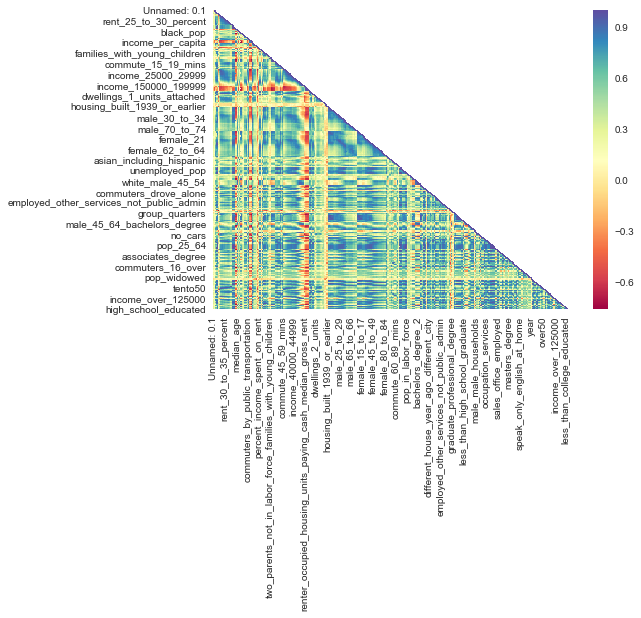

In [170]:
num_features = x_train.select_dtypes(include = ['int64', 'float64'])
corr_x_train =  num_features.corr(method = 'pearson') 
matrix = corr_x_train.where(np.tril(np.ones(corr_x_train.shape)).astype(np.bool))

hmap = sns.heatmap(matrix, cmap = "Spectral")
hmap

### 2.4 Outlier detection

#### In order to detect outliers Cook´s distance is implemented. The observations that are signal out are appended to a list. We also try to identify outliers by checking whether they fall out of the inter quantile range (IQR). These outliers are also appended to a different list. Afterwards, we decide to drop the outliers that appear in both lists. The reason we follow this approach is that the Cook´s distance assumes an ordinary least square regression in order to identify outliers. Given that we also plan to implement different linear models (lasso and ridge in particular), it was decided to also use the IQR.

#### IQR outlier detection.

In [171]:
train = pd.concat([y_train, x_train], axis = 1)

# Define a function that will detect outliers according to the following boundaries:
def outlier_detection(feature): 
    sorted(feature) 
    q1,q3 = np.percentile(feature , [25,75]) 
    IQR = q3 - q1 
    lower_range = q1 - (3 * IQR) 
    upper_range = q3 + (3 * IQR) 
    return lower_range,upper_range

# Apply the function above to all numerical variables in the dataframe. Outliers found for every variable will be stored
# in a list and then append it to a nested list that contains all of the outlier´s indexes (so one list per variable within
# the nested list).
num_features = train.select_dtypes(include = ['number']).columns
outliers = {}
list_outliers = []
for feature in num_features:
    outlier_detection(train[feature])
    lower_range, upper_range = outlier_detection(train[feature])
    overall_qual_drop = train[(train[feature] < lower_range) | (train[feature] > upper_range)]
    outliers[feature] = list(overall_qual_drop.index)
    list_outliers.append(list(overall_qual_drop.index))

# Flatten the nested list so that we have a list with all the outliers´ indexes detected for each variable.
flat_list = []
for sublist in list_outliers:
    for item in sublist:
        flat_list.append(item)

# Create a dictinary with the counts of every outlier, so that we know how many times a single observation has been 
# classified as an outlier. We then sort the dictionary by descending order.
repeated_outliers = {i: flat_list.count(i) for i in flat_list}
repeated_outliers = sorted(repeated_outliers.items(), key = lambda x: x[1], reverse = True)

# We plot the output:
print('Number of times an observation is classified as an outlier:')
print('  ')
print('Nº       Index')
for index, outliers in repeated_outliers:
    print('{}        {}'.format(outliers, index))

Number of times an observation is classified as an outlier:
  
Nº       Index
12        2259
12        2267
12        2275
12        2235
12        2299
12        2243
12        2251
12        2291
12        2211
12        2227
11        297
11        345
11        353
11        361
11        369
11        337
11        313
11        305
11        289
11        377
11        819
11        843
11        811
11        851
11        787
11        827
11        803
11        779
11        835
11        225
11        232
11        280
11        202
11        281
11        258
11        248
11        264
11        226
11        265
11        208
11        217
11        249
11        201
11        250
11        210
11        282
11        209
11        218
11        224
11        193
11        200
11        272
11        241
11        273
11        256
11        192
11        233
11        257
11        216
11        274
10        376
10        288
10        346
10        360
10        344
10

In [179]:
outlier_index = []
for i in range(0,260):
    outlier_index.append(repeated_outliers[i][0])
print('The outliers to be removed from the dataframe are {}'.format(outlier_index))

The outliers to be removed from the dataframe are [2259, 2267, 2275, 2235, 2299, 2243, 2251, 2291, 2211, 2227, 297, 345, 353, 361, 369, 337, 313, 305, 289, 377, 819, 843, 811, 851, 787, 827, 803, 779, 835, 225, 232, 280, 202, 281, 258, 248, 264, 226, 265, 208, 217, 249, 201, 250, 210, 282, 209, 218, 224, 193, 200, 272, 241, 273, 256, 192, 233, 257, 216, 274, 376, 288, 346, 360, 344, 312, 370, 328, 368, 304, 362, 354, 322, 298, 352, 330, 296, 306, 320, 290, 842, 802, 858, 840, 834, 856, 219, 792, 776, 275, 243, 259, 283, 235, 826, 770, 832, 810, 267, 203, 195, 800, 786, 848, 808, 818, 251, 794, 211, 768, 778, 2273, 2242, 2217, 2241, 2249, 2225, 2282, 2233, 2257, 2265, 2266, 2297, 2298, 2218, 2258, 2290, 2209, 2320, 2344, 2384, 2336, 2376, 2304, 2392, 2360, 2352, 2368, 833, 793, 785, 777, 817, 841, 809, 801, 1496, 1488, 64, 1448, 88, 1528, 32, 1472, 72, 1512, 40, 8, 16, 80, 1464, 24, 1440, 48, 1480, 56, 1504, 1520, 2248, 2208, 2224, 2280, 2272, 2232, 2216, 2296, 2288, 2240, 1841, 2673, 1

#### Cook´s distance outlier detection.

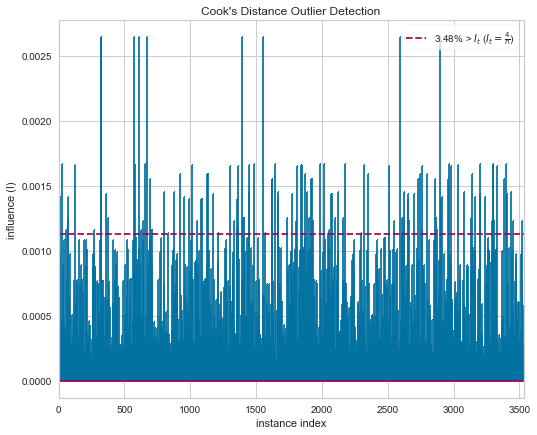

In [172]:
from yellowbrick.base import Visualizer
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance(size = (600, 500))
z = x_train.select_dtypes(include = ['int64', 'float64'])
visualizer.fit(z, y_train)
visualizer.poof()

In [180]:
outliers = visualizer.distance_ >= visualizer.influence_threshold_
outliers = list(outliers[outliers == True].index)

outlier = []
for i in range(1,len(outliers)):
    if outliers[i] in outlier_index:
               outlier.append(outliers[i])

In [182]:
x_train.drop(index = outlier, inplace = True)
y_train.drop(index = outlier, inplace = True) 

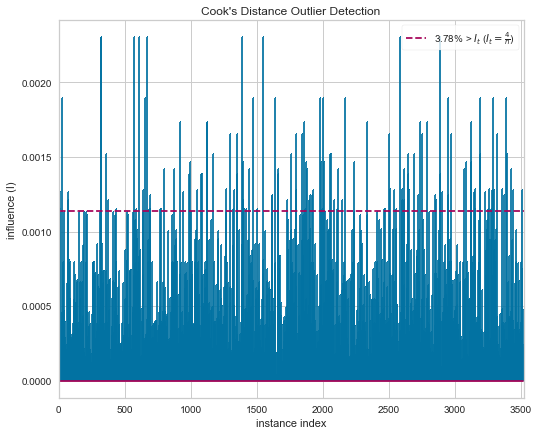

In [183]:
visualizer = CooksDistance(size = (600, 500))
z = x_train.select_dtypes(include = ['int64', 'float64'])
visualizer.fit(z, y_train)
visualizer.poof()

### 2.5 Yeo-Johnson transformation

#### Before implementing any transformation, we plot the distribution of our numerical variables:

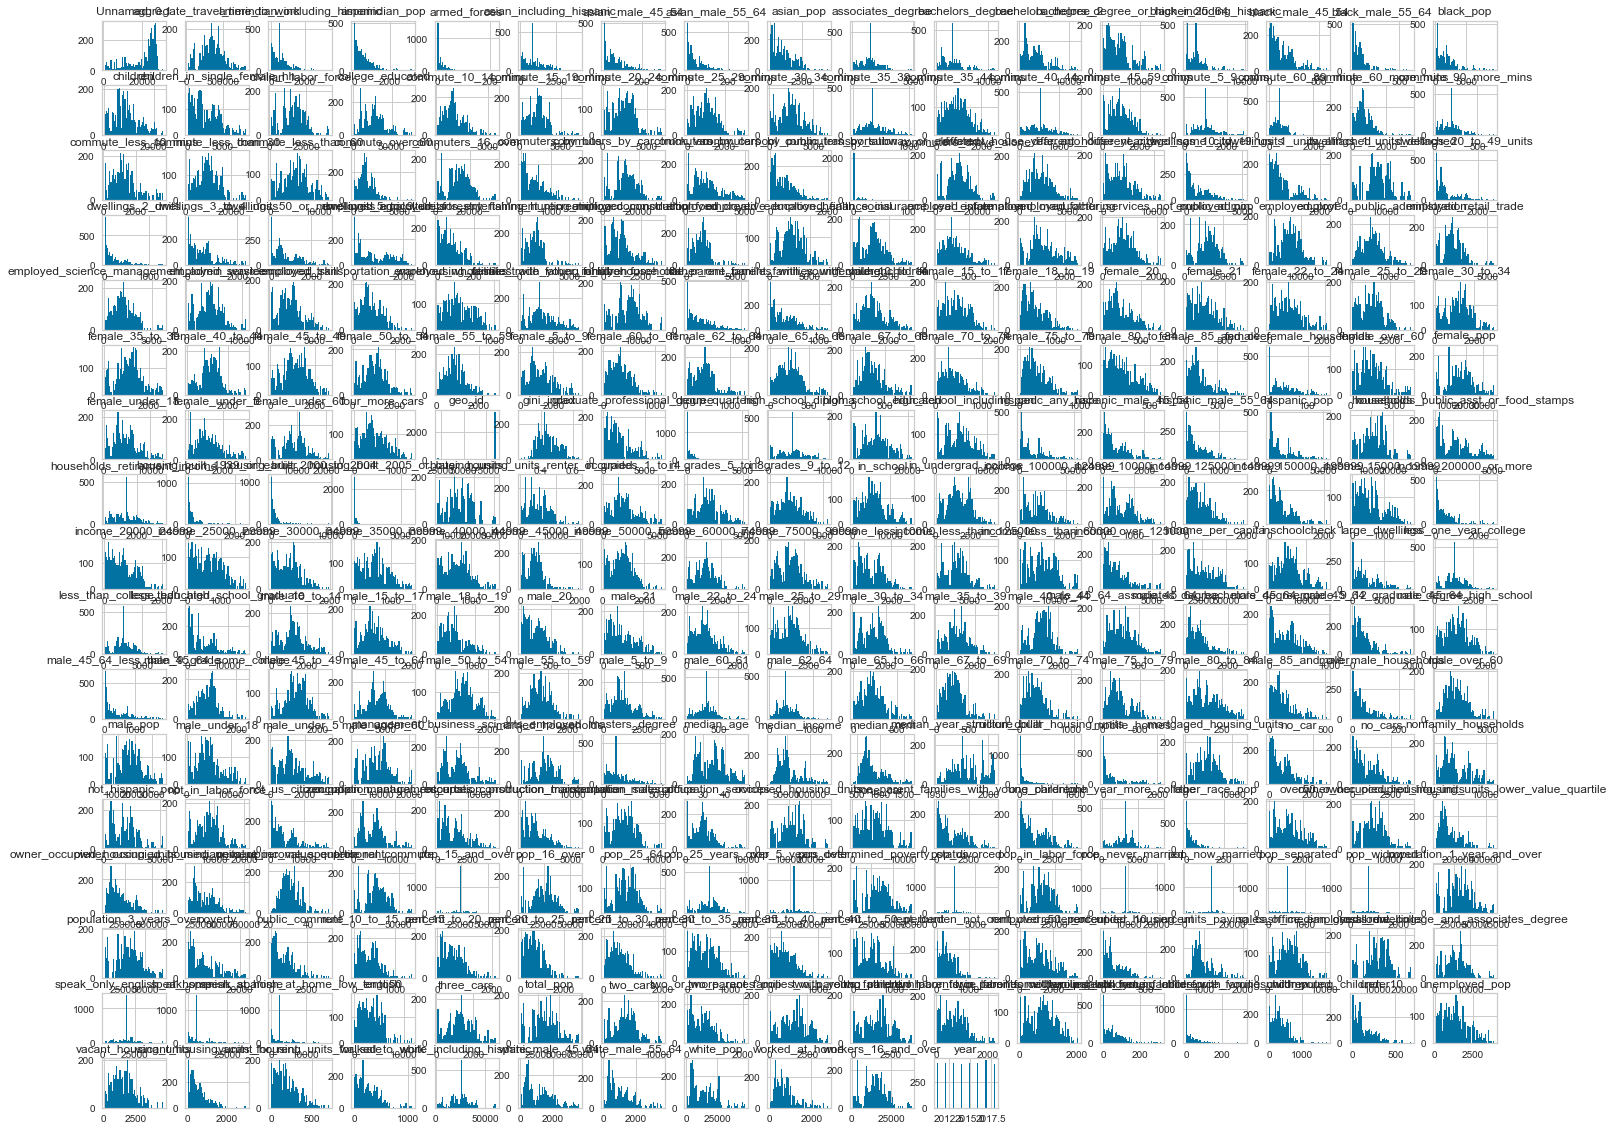

In [184]:
x_train.select_dtypes(include = ['int64', 'float64']).hist(bins = 50, figsize = (25,20))
plt.show()

#### We can see how the continuous numerical variables are right skewed. In order to correct for this, we try a yeo-johnson transformation to normalize our features. There are three reasons why the yeo-johnson transformation is chosen: 
#### 1. Many of our features we have zero values and the box-cox transformation demands strictly positives values.
#### 2. Yeo-johnson tranformation allows to train in the training data and then apply to the testing data. Therefore, it keeps the rigour we need to keep to then realistically evaluate our model. 
#### 3. Yeo-johnson transformation also scales the data and centers it around zero.

In [ ]:
# COMPARE WITH OTHER CITIES AND SEE CHANGES

In [185]:
from sklearn.preprocessing import PowerTransformer
    
pt = PowerTransformer(method = 'yeo-johnson')
for feature in list(x_train.select_dtypes(include = ['int64', 'float64'])):
    x_train[feature] = pt.fit_transform(x_train[feature].to_numpy().reshape(-1,1))
    x_test[feature] = pt.transform(x_test[feature].to_numpy().reshape(-1,1))    

C:\Users\Guillermo\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


#### We now check how the yeo-johnson transformation scaled and normalized our data. 

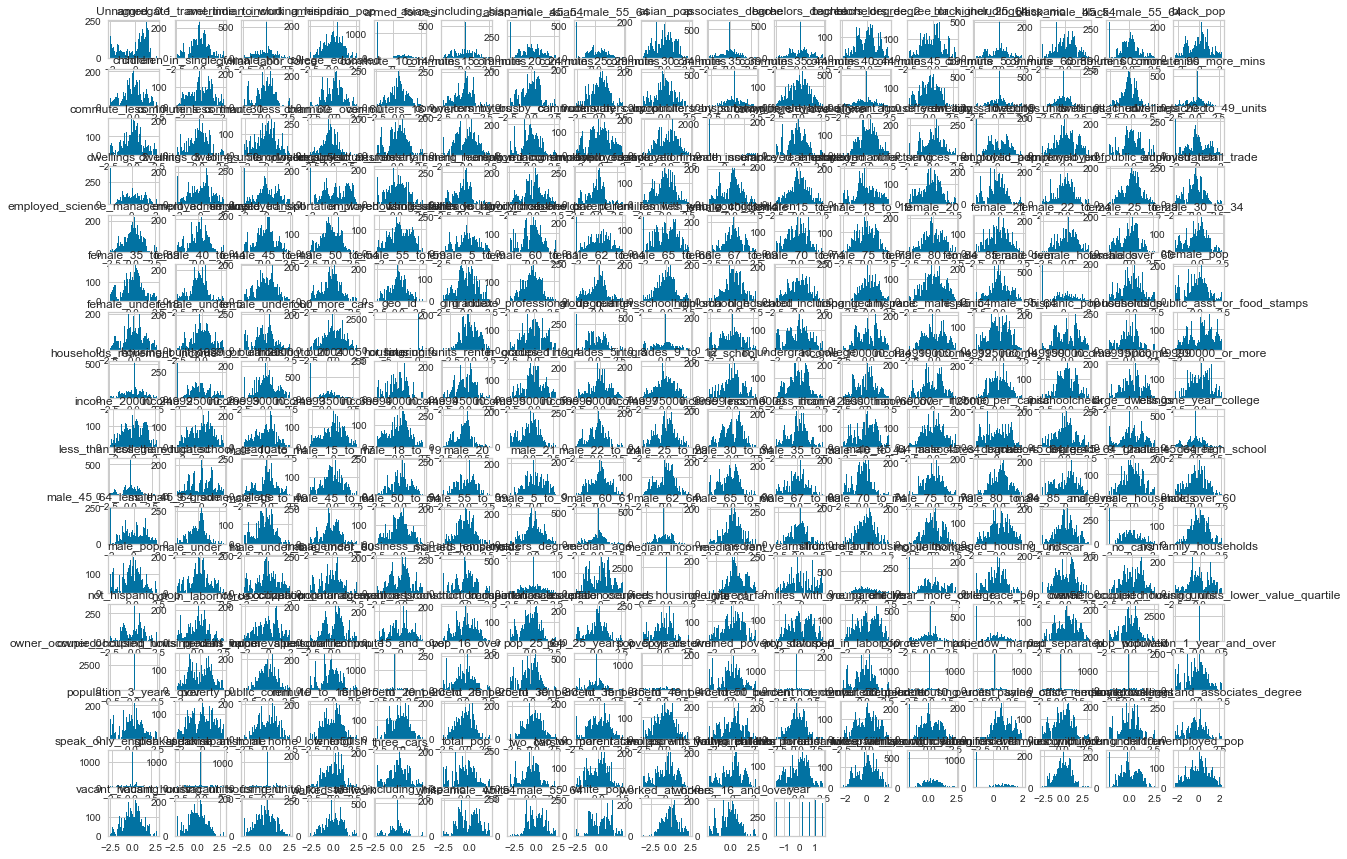

In [186]:
x_train.select_dtypes(include = ['int64', 'float64']).hist(bins = 50, figsize = (20,15))
plt.show()

### 2.5 Target variable´s logarithmic transformation 

#### The distribution of the dependent variables is right skewed. This will be a problem when implementing linear models. 

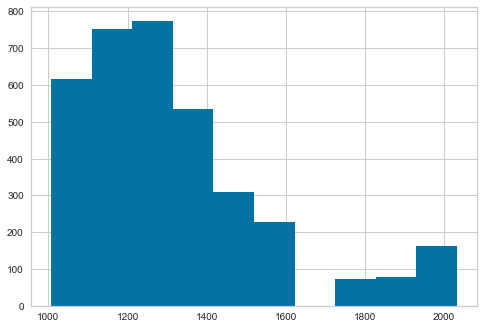

In [49]:
y_train.hist()

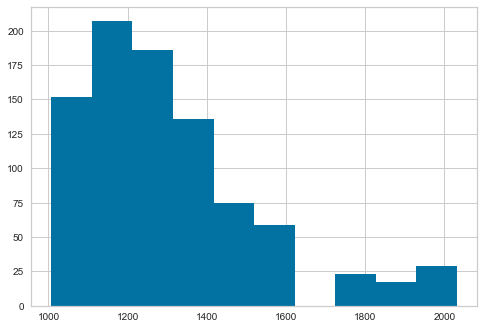

In [50]:
y_test.hist()

#### Because of this reason, we perform a logarithmic transformation on the dependent variable. We then check that it is now normally distributed in both the training and testing datasets.

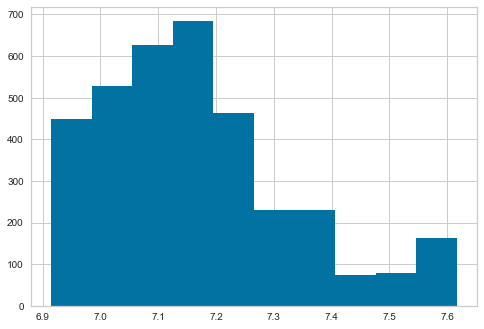

In [187]:
# We apply the logarithmic transformation.
y_train = y_train.apply(lambda x: np.log(x))

# We check the new dependent variable´s distribution.
y_train.hist() 

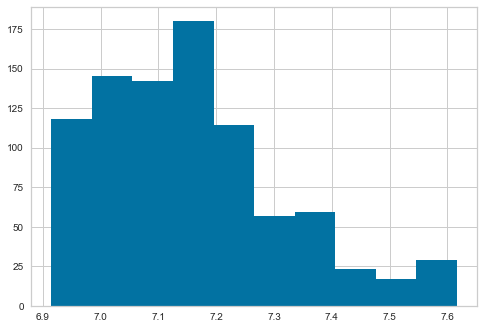

In [188]:
# We apply the logarithmic transformation.
y_test = y_test.apply(lambda x: np.log(x))

# We check the new dependent variable´s distribution.
y_test.hist() 

## 3. Lasso Regression

#### As explained before, our multiple linear regression model suffers from multicollinearity. In order to solve this problem we move on to try regression models with regularization properties. In the first place, we try the lasso regression. The steps to follow are:
#### 1. We implement the lasso regression model and check the R-squared for the training and testing dataframes and the degree of regularization in the model. 
#### 2. We tune the hyperparameters using cross-validation and use them to fit a new model, thus trying to find the right balance between accuracy and variance of the model, avoiding over-fitting.
#### 3. Test linear models assumptions.
#### 4. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 3.1 Implement the lasso regression model

In [189]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)

# Check the model´s performance.
print('Training set R-squared is {}'.format(lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(lasso.alpha))
# WOULD YOU PUT THIS TOGETHER OR PUT THE CHECK PERFORMANCE IN A DIFFERENT CELL? HOW TO BEST STRUCTURE THE CHUNKS? 
# Separate and leave markdown comment.

Training set R-squared is 0.0
Testing set R-squared is -0.0022595424381386398
Amount of penalization is 1.0


### 3.2 Tune the hyperparameters using cross-validation and fit a new model

In [200]:
from sklearn.linear_model import LassoCV
cv_lasso = LassoCV(n_alphas = 200, cv = 10, max_iter = 1500, fit_intercept = True) 
cv_lasso.fit(x_train, y_train)

# HOW AM I GETTING WORSE PERFORMANCE WITH CROSS-VALIDATION?

# Check Lasso´s performance and best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))

C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010209213133520745, tolerance: 0.009050443042233637
  tol, rng, random, positive)
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009530679632825168, tolerance: 0.009050443042233637
  tol, rng, random, positive)
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013892314796706273, tolerance: 0.009050443042233637
  tol, rng, random, positive)
C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Ob

Training set R-squared is 0.9870396165401735
Testing set R-squared is 0.9738817934283588
Amount of penalization is 0.0001472421737190288


C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32187621868856575, tolerance: 0.010077672362105097
  positive)


### 3.3 Test linear model assumptions

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 0.3238575228597946 and the p-value is 0.5692985851729454


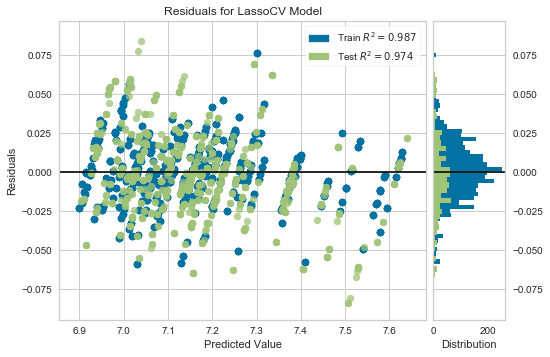

In [201]:
# Bartlett’s test
residuals = cv_lasso.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

from scipy import stats
import scipy.stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(cv_lasso)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 

#### 2. Normality of the residuals assumption



#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 12.216330346461445 and the p-value is 0.0022246288790005453
Shapiro-Wilk statistic is 0.9875085353851318 and the p-value is 7.579259886369982e-07
Anderson-Darling statistic is 3.736458897243665 and the p-values are [0.573 0.653 0.783 0.914 1.087]
Kolmogorov-Smirnov statistic is 0.47029495846693814 and the p-value is 7.227099922627689e-180


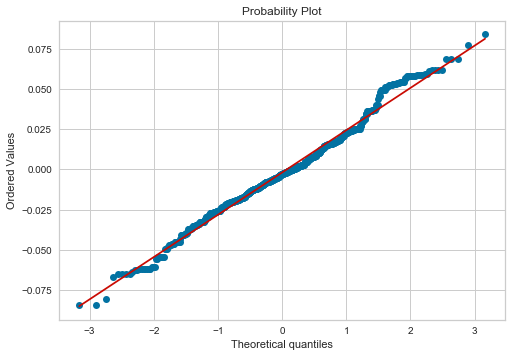

In [202]:
from scipy import stats
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
import pylab 
import scipy.stats as stats
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Because of this reason, we will compare the predictions of the model against the y_test prices we are trying to predict. 

#### 3. Independence of the residuals assumption





#### Same as with the multiple linear regression model, a Durbin-Watson test is implemented to evaluate whether the residuals are indepentent.

In [203]:
from statsmodels.stats.stattools import durbin_watson

db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 2.051524260777139


#### From the result above we can conclude that our residuals are independent. 

### 3.4 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [204]:
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)

# Check accuracy with MSE
from sklearn.metrics import mean_squared_error
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with the test dataset.
from sklearn.metrics import mean_absolute_error
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0007006218751860659
The root mean squared error (RMSE) is 0.02646926283797994
The mean absolute error (MAE) is 0.020280290587991627


## 4. Ridge Regression

#### Ridge regression is another linear model that allows regularization. We follow the same steps as before when implementing lasso: 
#### 1. Implement the ridge regression model, check the R-squared for the training and testing dataframes and the degree of regularization in the model. 
#### 2. Tune the hyperparameters using cross-validation and use them to fit a new model.
#### 3. Evaluate wether the linear regression assumptions hold.
#### 4. Generate a prediction using our model and comparing it to the testing dataset (y_test) to evaluate its accuracy.  

### 4.1 Implement the ridge model

In [205]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(x_train, y_train)

# Check the model´s performance
print('Training set R-squared is {}'.format(ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(ridge.alpha))

Training set R-squared is 0.9950058715721524
Testing set R-squared is 0.9597115436142076
Amount of penalization is 1.0


### 4.2 Tune the hyperparameters using cross-validation

In [216]:
from sklearn.linear_model import RidgeCV
cv_ridge = RidgeCV(alphas = np.linspace(8, 100, 100), cv = 3, normalize = False, fit_intercept = True)
cv_ridge.fit(x_train, y_train)

# Check Ridge best parameters as outcomes of cross validation.
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))

Training set R-squared is 0.9922619369340921
Testing set R-squared is 0.9719063603519164
Amount of penalization is 8.0


In [ ]:
# PROBLEM WITH THIS CROSS VALIDATION

### 4.3 Evaluate linear models assumptions

#### 1. Homoskedasticity assumption. 

#### We run a bartlett test by splitting the residual´s array into two different arrays to test if they have the same variance (bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances).

#### We also plot the residuals plot to have a visual representation of the residuals distribution and check whether there is heteroskedasticity. 

The bartlett test´s statistics is 0.132136606186117 and the p-value is 0.7162269376833198


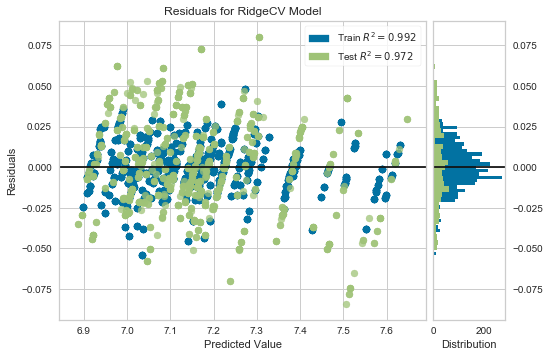

In [217]:
# Bartlett’s test
residuals = cv_ridge.predict(x_test) - y_test

split_array = np.split(residuals, 2)
sample1 = split_array[0]
sample2 = split_array[1]

import scipy.stats
bartlett = stats.bartlett(sample1, sample2)
print('The bartlett test´s statistics is {} and the p-value is {}'.format(bartlett[0], bartlett[1]))

# Plot residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(cv_ridge)

# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)  
# Evaluate the model on the test data
visualizer.score(x_test, y_test)  
# Finalize and render the figure
visualizer.show()                 

#### The plot allows us to check that there is not heteroskedasticity. In addition, the bartlett’s test p_value does not suffice to reject the null hypothesis (equal variances). Therefore, we can conclude that the homoskedasticity assumption holds. 




#### 2. Normality of the residuals assumption

#### In order to check normality a Q-Q plot is visualized below. Also, a battery of normality test are run: Jarque-Bera test, Shapiro-Wilk test, Anderson-Darling test and the Kolmogorov-Smirnov test.

Jarque_bera statistic is 0.8822340763835568 and the p-value is 0.6433174094603804
Shapiro-Wilk statistic is 0.9959167838096619 and the p-value is 0.019982393831014633
Anderson-Darling statistic is 1.1182609618466586 and the p-values are [0.573 0.653 0.783 0.914 1.087]
Kolmogorov-Smirnov statistic is 0.46804929303933795 and the p-value is 4.6854514892061996e-178


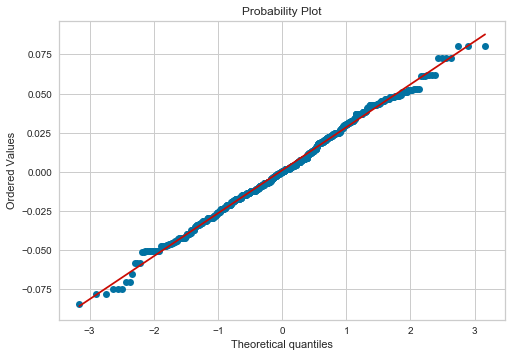

In [218]:
from scipy import stats
# Jarque_bera test
jb = stats.jarque_bera(residuals)
print('Jarque_bera statistic is {} and the p-value is {}'.format(jb[0], jb[1]))
# Shapiro-Wilk test
sw = stats.shapiro(residuals)
print('Shapiro-Wilk statistic is {} and the p-value is {}'.format(sw[0], sw[1]))
# Anderson-Darling test
ad = stats.anderson(residuals, dist = 'norm')
print('Anderson-Darling statistic is {} and the p-values are {}'.format(ad[0], ad[1]))
# Kolmogorov-Smirnov test
ks = stats.kstest(residuals, 'norm')
print('Kolmogorov-Smirnov statistic is {} and the p-value is {}'.format(ks[0], ks[1]))

# Plot Q-Q graph
stats.probplot(residuals, dist = "norm", plot = pylab)
pylab.show()

#### The plot shows that the residuals don´t follow an exact normal distribution. The battery of tests confirm this result. The fact that the normality assumptions does not hold should make us skeptical of the reliability of the model. Because of this reason, we will compare the predictions of the model against the y_test prices we are trying to predict. This allows an empirical comprobation. 


#### 3. Independence of the residuals assumption

#### Same as with the multiple linear regression model and the lasso model, a Durbin-Watson test is implemented to evaluate whether the residuals are indepentent.

In [219]:
db = durbin_watson(residuals, axis = 0)

print('The Durbin_Watson statistics is {}'.format(db))

The Durbin_Watson statistics is 2.032905916615259


#### From the result above we can conclude that our residuals are independent. 

### 4.4 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [220]:
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

The mean squared error (MSE) is 0.0007536129418783867
The root mean squared error (RMSE) is 0.027452011618065198
The mean absolute error (MAE) is 0.021887562080474873


## 5. Gradient Boosting

#### In addition to the linear models implemented above, we also try non-linear, tree-based, models. There may be non-linear relationships in our data that our tree-models are able to capture, perhaps offering better performance that the linear models tried above. We will start by implement gradient boosting and then we will turn to random forest.

#### The steps to follow when implement gradient boosting are:
#### 1. Implement the gradient boosting model and check its R-squared for both the training and testing sets. 
#### 2. Tune the hyperparameters using cross-validation. This process allows to avoid overfitting that may have been suggested in the first step.
#### 3. Perform a prediction using our cross-validated model. Then, this predictions will be evaluated against our prices in the testing dataset (y_test).

### 5.1 Implement the gradient boosting model

In [221]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(gbr.score(x_train, y_train)))
print('The testing R-squared is {}'.format(gbr.score(x_test, y_test)))

The training R-squared is 0.999003100690337
The testing R-squared is 0.9906722555034687


### 5.2 Tune hyperparameters using cross-validation 

#### The cross-validation shown below is the result of different trials adjusting the hyperparameters. Only the final option has been kept in order to save time when running the code.

In [224]:
# Fit cross-validated
grid_boosting = {'learning_rate':np.linspace(0.10, 0.5, 5), 'n_estimators':[50,125,200], 'max_depth': np.linspace(1, 100, 5), 'criterion':['mae']}
cv_gbr = GridSearchCV(gbr, grid_boosting, cv = 3)
cv_gbr.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format((cv_gbr.score(x_train, y_train))))
print('The testing R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('Chosen hyperparameters are: {}'.format(cv_gbr.best_params_))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Guillermo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-224-b8787fd9d814>", line 4, in <module>
    cv_gbr.fit(x_train, y_train)
  File "C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 710, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1151, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\Guillermo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 689, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\Users\Guillermo\Anaconda3\lib\site-packages\joblib\parallel.py", line 924, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\Guillermo\Anaconda3\lib\site-packages\joblib\parallel.py", line

KeyboardInterrupt: 

### 5.3 Generate and evaluate the prediction

#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [ ]:
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

## 6. Random Forest

#### A random forest model is now implemented. The steps to follow are:
#### 1. Implement the random forest model and check its R-squared for both the training and testing sets. 
#### 2.Tune the hyperparameters using cross-validation. This process allows to avoid overfitting that may have been suggested in the first step.
#### 3. Perform a prediction using the cross-validated model. Then, this predictions will be evaluated against our prices in the testing set (y_test).

### 6.1 Implement the random forest model

In [ ]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.fit(x_train, y_train)

# Check score without cross-validation
print('The training R-squared is {}'.format(randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(randomForest.score(x_test, y_test)))

### 6.2 Tune hyperparameters using cross-validation 

In [172]:
# Fit the cross-validated model
from sklearn.model_selection import GridSearchCV
grid_randomForest = {'n_estimators': [50,100,150,200], 'max_depth': np.linspace(10, 15, 5), 'criterion':['mae']} 
cv_randomForest = GridSearchCV(randomForest, grid_randomForest, cv = 3)
cv_randomForest.fit(x_train, y_train)

# Selecting optimal parameters
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('Best parameters are {}'.format(cv_randomForest.best_params_))

The training R-squared is 0.9824324567252399
The testing R-squared is 0.8692093068460013
Best parameters are {'criterion': 'mae', 'max_depth': 47, 'n_estimators': 114}


#### Once we have our model, we predict prices for the houses in the testing dataset. This results in a vector that can be compared with the actual testing dataset (y_test). We test the accuracy of the predictions calculating the mean absolute error.

In [ ]:
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

## 7. Summary

#### We plot below the R-squared and the evaluation of the predictiosn from the implemented models to allow for an easier comparison.

In [72]:
print('============================================ LASSO ==============================================================')
print('Training set R-squared is {}'.format(cv_lasso.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_lasso.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_lasso.alpha_))
print('------------------------------------------ Predictions --------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_lasso.predict(x_test)
# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('============================================ RIDGE ==============================================================')
print('Training set R-squared is {}'.format(cv_ridge.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_ridge.score(x_test, y_test)))
print('Amount of penalization is {}'.format(cv_ridge.alpha_))
print('------------------------------------------ Predictions --------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_ridge.predict(x_test)
# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('========================================== BOOSTING ============================================================')
print('Training set R-squared is {}'.format(cv_gbr.score(x_train, y_train)))
print('Testing set R-squared is {}'.format(cv_gbr.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_gbr.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

print('========================================== RANDOM FOREST ========================================================')
print('The training R-squared is {}'.format(cv_randomForest.score(x_train, y_train)))
print('The testing R-squared is {}'.format(cv_randomForest.score(x_test, y_test)))
print('------------------------------------------ Predictions ---------------------------------------------------------')
# Predict SalePrices with the model.
prediction = cv_randomForest.predict(x_test)

# Check accuracy with MSE
print('The mean squared error (MSE) is {}'.format(mean_squared_error(y_test, prediction)))

# Check accuracy with RMSE
print('The root mean squared error (RMSE) is {}'.format(sqrt(mean_squared_error(y_test, prediction))))

# Check the accuracy of the model with MAE
print('The mean absolute error (MAE) is {}'.format(mean_absolute_error(y_test, prediction)))

============================================ LASSO ==============================================================
Training set R-squared is 0.9621280340898799
Testing set R-squared is 0.9262953350654111
Amount of penalization is 0.00014764461078108096
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.001977130413406769
The root mean squared error (RMSE) is 0.0444649346497526
The mean absolute error (MAE) is 0.03346020056766884
============================================ RIDGE ==============================================================
Training set R-squared is 0.9601272179462153
Testing set R-squared is 0.9237494323987511
Amount of penalization is 18.0
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.0020454243483468974
The root mean squared error (RMSE) is 0.04522636784384633
The mean absolu

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

In [ ]:
============================================ LASSO ==============================================================
Training set R-squared is 0.9621280340898799
Testing set R-squared is 0.9262953350654111
Amount of penalization is 0.00014764461078108096
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.001977130413406769
The root mean squared error (RMSE) is 0.0444649346497526
The mean absolute error (MAE) is 0.03346020056766884
============================================ RIDGE ==============================================================
Training set R-squared is 0.9601272179462153
Testing set R-squared is 0.9237494323987511
Amount of penalization is 18.0
------------------------------------------ Predictions --------------------------------------------------------
The mean squared error (MSE) is 0.0020454243483468974
The root mean squared error (RMSE) is 0.04522636784384633
The mean absolute error (MAE) is 0.03372449012654034

#### The best performing model is the ridge regression. Given that it is the model that better predicts our prices, we can try to get information out of it:
#### 1. What are the features that have a higher impact in the price of a house?


In [175]:
# Create a dictionary with the features and their respective coefficients
coef_dict = {}
for coef, feature in zip(cv_ridge.coef_, x_train.columns):
    coef_dict[feature] = coef

# Sort the dictionary by its values to find the most relevant variables    
from collections import OrderedDict
OrderedDict(sorted(coef_dict.items(), key = lambda x: x[1]))    

OrderedDict([('KitchenAbvGr', -0.04302758290484997),
             ('Neighborhood_Edwards', -0.038525562924186484),
             ('BsmtFinType1_Unf', -0.0384537024427584),
             ('Neighborhood_IDOTRR', -0.035322593043430196),
             ('GarageCond_Fa', -0.03272355882084799),
             ('GarageYrBlt_1965.0', -0.03271950077663971),
             ('Neighborhood_Mitchel', -0.0319812127144564),
             ('BsmtQual_TA', -0.030350368375408533),
             ('KitchenQual_Gd', -0.02964166331152982),
             ('BsmtQual_Gd', -0.028343473184261128),
             ('Functional_Maj2', -0.02760999206847353),
             ('Neighborhood_NWAmes', -0.027401281239043056),
             ('GarageYrBlt_1977.0', -0.02676948156904149),
             ('Condition1_RRAe', -0.025960057314581238),
             ('LandContour_Low', -0.024956883838483546),
             ('BsmtUnfSF', -0.022562428619270124),
             ('SaleCondition_Family', -0.021952252100755063),
             ('KitchenQual_TA',

#### The top 5 features that with a higher positive impact in the price of the house are:
#### 1. TotalSF
#### 2. OverallQual
#### 3. Neighborhood_Crawfor
#### 4. GrLivArea
#### 5. Condition1_Norm

#### The botton 5 features are:
#### 1. KitchenAbvGr
#### 2. Neighborhood_Edwards
#### 3. BstFinType1_Unf
#### 4. Neighborhood_IDOTRR
#### 5. GarageCond_Fa

#### The variable having the biggest causal effect in prices is total square footage. Second one is OverallQual, which reflects overall material and finish quality. These are expected result. 
#### Proximity to main road or railroad is also withing the top 5 features.  This can be important in case of new developments.
#### There are 3 features reflecting different neighborhoods between the top and button 5 features in terms of having an effect on price. This speaks to the importance of where the new developments take place. Crawfor seems to be the neighborhood that positively affects the prices most. This does not mean that it is the neighborhoods with the most expensive housing, just that building in that location has a the biggest positive causal effect. 
#### When a garage conditioning is ranked as 'fair', it has little impact in the price of the house (fifth from the button). On the other hand, garages that are ranked as 'Average', just slightly higher quality than 'fair' have a significantly higher effect in the price of the house. This suggest that trying to upgrade low-quality garages to average ones can have a positive impact in the profits as the increase in revenue will probably outweigh the costs.
#### Another insight comes from the fact that an unfinished basement has little effect in the price of houses. When remodeling houses this can kept in mind, as maybe it´s not worth the cost to finish the basement.